# AutoEncoder

![autoencoder](./images/autoencoder2.png)

지도학습은 단순히 말해 입력 x와 정답 y 사이의 관계를 찾는 것이고, 비지도 학습은 정답이 없는 채로 x를 예측하는 것이다.

즉 오토인코더에서는 입력도 x, 정답도 x로 설계된 신경망이다.

단, 신경망은 범용근사자(univeral function approximator)로서 근사치를 출력하므로 x와 똑같은 출력을 내긴 힘들다.

그러므로 오찻값에도 x를 얼마나 복원했는지를 뜻하는 복원오차, 혹은 정보손실값(reconstruction loss)이라는 용어를 사용한다.

오토인코더는 입력과 출력의 크기는 같지만 중간으로 갈수록 신경망의 차원이 줄어든다.

작은 차원으로 압축된 표현을 잠재변수(latent variable)라 하고, 간단히 z라고 한다.

잠재 변수의 앞뒤를 구분하여 앞부분을 인코더(encoder), 뒷부분을 디코더(decoder)라고 한다.

인코더는 정보를 받아 압축하고, 디코더는 압축된 표현을 풀어 입력을 복원하는 역할을 한다.

오토인코더에서는 필연적으로 정보의 손실이 일어나지만 이는 중요한 정보만 남겨두는 일종의 데이터 가공이라고 볼 수 있다. 

이런 특징으로 인해 오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 쓰인다.

# Import

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #생성되는 이미지를 관찰하기 위함입니다. 3차원 플롯을 그리는 용도입니다.
from matplotlib import cm # 데이터포인트에 색상을 입히는 것에 사용됩니다.
import numpy as np

C:\Users\pinb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper Params

In [2]:
# 하이퍼파라미터 준비
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


# Dataset (Fashion-MNIST)

![fation-mnist](./images/fashionmnist.jpg)
* Fashion-MNIST는 총 70,000개의 그레이스케일 이미지로 구성된다. 
* 60,000개는 학습용 데이터, 10,000개는 테스트용 데이터 
* 데이터셋은 10가지 범주로 구성 ('티셔츠/탑', '바지', '풀오버', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클 부츠' 등)
* 각 이미지는 28x28x1 크기

In [3]:
# Fashion MNIST 데이터셋 불러오기 (학습데이터만 사용)
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

100%|██████████| 26421880/26421880 [00:06<00:00, 4076925.90it/s]


Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 118201.02it/s]


Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1360040.16it/s]


Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



# Autoencoder Network

In [4]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        #인코더는 간단한 신경망으로 분류모델처럼 생겼습니다.
        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Linear(28*28, 128), #차원을 28*28에서 점차 줄여나갑니다.
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다 (출력값이 바로 잠재변수가 됩니다.)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), #디코더는 차원을 점차 28*28로 복원합니다.
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 잠재변수를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) 
# Adam()을 최적화함수로 사용합니다. Adam은 SGD의 변형함수이며 학습중인 기울기를 참고하여 학습 속도를 자동으로 변화시킵니다.
criterion = nn.MSELoss() #원본값과 디코더에서 나온 값의 차이를 계산하기 위해 평균제곱오차(Mean Squared Loss) 오차함수를 사용합니다.

# Data Normalize

In [6]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
# 복원이 어떻게 되는지 관찰하기 위해 5개의 이미지를 가져와 바로 넣어보겠습니다.
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

# Train

In [7]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE) #x(입력)와 y(대상 레이블)모두 원본이미지(x)인 것을 주의해야 합니다.
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # decoded와 원본이미지(y) 사이의 평균제곱오차를 구합니다
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

[Epoch 1]


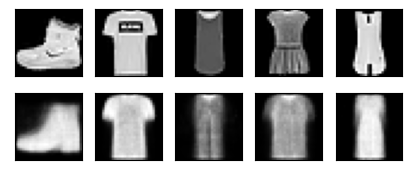

[Epoch 2]


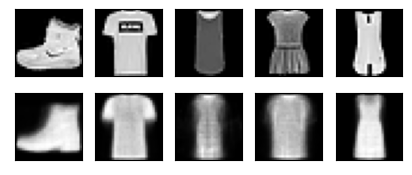

[Epoch 3]


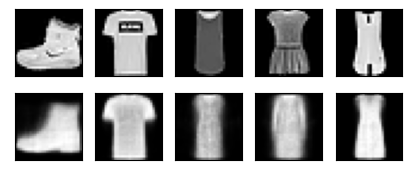

[Epoch 4]


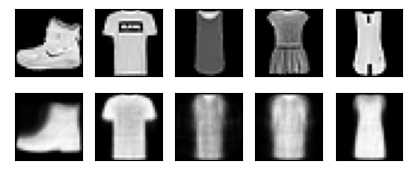

[Epoch 5]


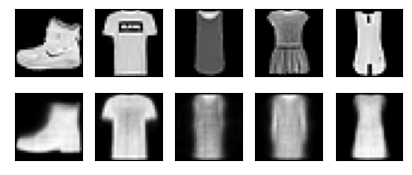

[Epoch 6]


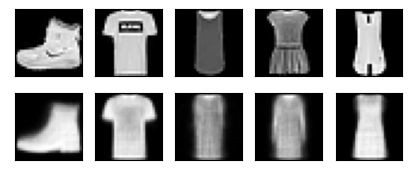

[Epoch 7]


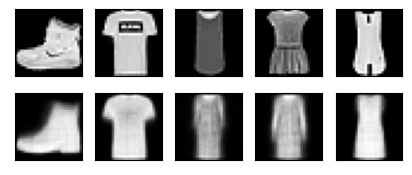

[Epoch 8]


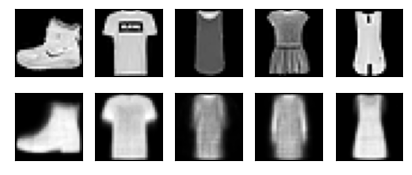

[Epoch 9]


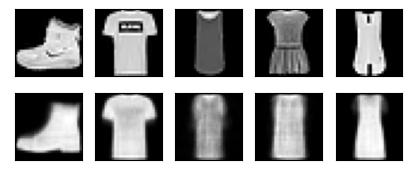

[Epoch 10]


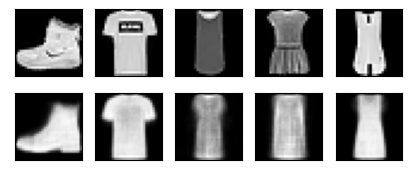

In [8]:
#학습하기
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기
    # 앞서 시각화를 위해 남겨둔 5개의 이미지를 한 이폭만큼 학습을 마친 모델에 넣어 복원이미지를 만듭니다.
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

참고: 도서 '펭귄브로의 3분 딥러닝 파이토치맛' ( 깃허브 : https://github.com/keon/3-min-pytorch )